In [7]:
!pip install insightface==0.7.3 opencv-python==4.8.1.78 onnxruntime==1.15.1 matplotlib


In [8]:
import insightface
import onnxruntime
import numpy as np
import cv2
from insightface.app import FaceAnalysis
import os
import matplotlib.pyplot as plt
import math


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Number of ma

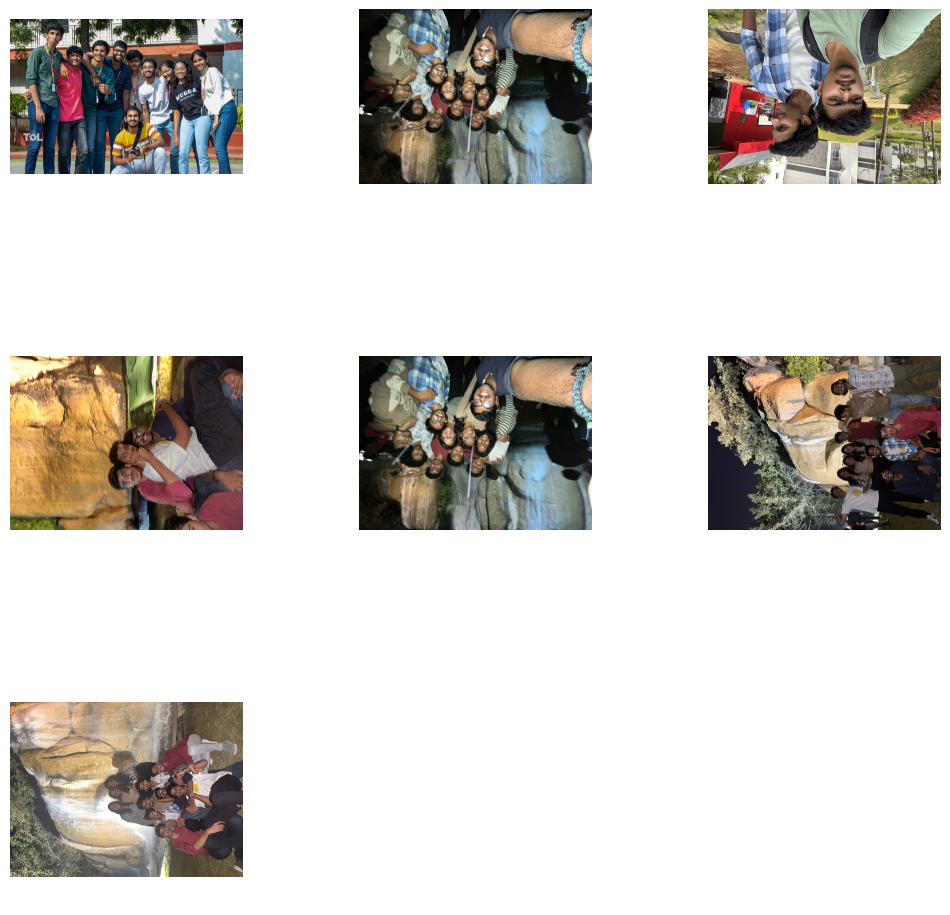

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis

def initialize_face_analysis():
    """Initializes the InsightFace FaceAnalysis model."""
    app = FaceAnalysis(name="buffalo_l")
    app.prepare(ctx_id=0, det_size=(640, 640))  # Set device and detection size
    return app

def detect_faces(image_path, app):
    """Detects faces and extracts embeddings."""
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image from: {image_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except ValueError as e:
        print(f"Error: {e}")
        return [], None

    faces = app.get(img)
    face_data = []
    for face in faces:
        bbox = face.bbox.astype(int)
        embedding = face.embedding
        face_data.append((bbox, embedding))
    return face_data, img

def store_embeddings(image_directory, app):
    """Scans a directory and stores embeddings for each face in the images."""
    embeddings_dict = {}
    for filename in os.listdir(image_directory):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(image_directory, filename)
            faces, _ = detect_faces(image_path, app)
            if faces:  # Ensure we have faces to store
                embeddings_dict[filename] = [embedding for _, embedding in faces]

    return embeddings_dict

def identify_person(target_image_path, image_directory, app, threshold=0.5):
    """Identifies images containing a specific person."""
    # Detect faces in the target image
    target_faces, _ = detect_faces(target_image_path, app)
    if not target_faces:
        print("No faces detected in the target image.")
        return []

    target_embeddings = [embedding for _, embedding in target_faces]  # Get all embeddings from target image
    matching_images = []

    # Store embeddings for all images in the directory
    embeddings_dict = store_embeddings(image_directory, app)

    for filename, embeddings in embeddings_dict.items():
        for embedding in embeddings:  # Compare each face embedding in the image
            for target_embedding in target_embeddings:
                # Compare embeddings using cosine similarity
                similarity = np.dot(target_embedding, embedding) / (np.linalg.norm(target_embedding) * np.linalg.norm(embedding))
                if similarity >= threshold:
                    matching_images.append(filename)
                    break  # Stop checking other faces once a match is found

    # Output number of matching images and their names
    matching_images = list(set(matching_images))  # Remove duplicates
    print(f"Number of matching images: {len(matching_images)}")
    print("Matching images:", matching_images)

    return matching_images

def display_images(image_paths):
    """Display the matching images in a grid."""
    num_images = len(image_paths)
    grid_size = int(np.ceil(np.sqrt(num_images)))

    # Create a grid of subplots to display images
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # Flatten axes array in case it's not already
    axes = axes.flatten()

    for i, image_path in enumerate(image_paths):
        row = i // grid_size
        col = i % grid_size
        img = plt.imread(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes

    # Hide any extra axes if there are fewer images
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.show()

if __name__ == "__main__":
    app = initialize_face_analysis()
    image_directory = "/content/drive/MyDrive/tt/"  # Replace with the directory containing your images
    target_image_path = "/content/drive/MyDrive/Screenshot 2024-11-29 at 9.48.50 PM.png"  # Replace with the path to the target image

    # Identify images containing the person in the target image
    matching_images = identify_person(target_image_path, image_directory, app)

    # Display the matching images
    if matching_images:
        image_paths = [os.path.join(image_directory, filename) for filename in matching_images]
        display_images(image_paths)
    else:
        print("No matching images found.")